# Исследование воронки продаж продуктов питания

<b>Цель проекта:</b> Изучить воронку продаж, проанализировать результаты A/A/B теста

<b>План исследования:</b>

1. Загрузить все необходимые библиотеки

2. Переименовать наименование столбцов и изменить тип данных, а также добавить отдельный столбец дат

3. Проверить на пропуски и дубликаты, при необходимости удалить строки, удаления которых не повлияет на итоговый результат

4. Проверить на аномальные значения

5. Проверить группы на наличие клиента в двух и более группах одновременно и на соотношение кол-ва клиентов в группах

6. Изучить и проверить данные

7. Изучить воронку событий

8. Проанализировать результаты тестирования и описать выводы/рекомендации

## Предобработка данных

In [1]:
%pip install -U kaleido -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
#загрузим все необходимые библиотеки

import pandas as pd
import datetime as dt
import scipy.stats as stats
import matplotlib.pyplot as plt
import math as mth
from plotly import graph_objects as go
import plotly.io as pio
pio.renderers.default = "png"
import seaborn as sns
sns.set(rc={'figure.figsize':(15,10)})


In [3]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
data.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [4]:
#приведем название столбцов в уднобный для анализа вид
data.columns = ['event_name', 'user_id', 'event_dt', 'group']
data.head(10)

,event_name,user_id,event_dt,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [5]:
#изменим тип данных и добавим поле c датами
data['event_dt'] = pd.to_datetime(data['event_dt'], unit='s')
data['dt'] = data['event_dt'].dt.date
data.head(10)

,event_name,user_id,event_dt,group,dt
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
5,CartScreenAppear,6217807653094995999,2019-07-25 11:48:43,248,2019-07-25
6,OffersScreenAppear,8351860793733343758,2019-07-25 14:50:42,246,2019-07-25
7,MainScreenAppear,5682100281902512875,2019-07-25 20:14:37,246,2019-07-25
8,MainScreenAppear,1850981295691852772,2019-07-25 20:31:42,247,2019-07-25
9,MainScreenAppear,5407636962369102641,2019-07-26 03:35:12,246,2019-07-26


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   event_dt    244126 non-null  datetime64[ns]
 3   group       244126 non-null  int64         
 4   dt          244126 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB


пропусков нет

In [7]:
#проверим на дубликаты
data.duplicated().sum()

413

In [8]:
print('Доля дубликатов:', round((data.duplicated().sum()/data['event_name'].count())*100, 2,), '%')

Доля дубликатов: 0.17 %


In [9]:
#удалим дубликаты и сохраним обновленный датафрейм
df = data.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

In [10]:
#проверим на анмомалии
df.describe()

,user_id,group
count,2.437130e+05,243713.000000
mean,4.627963e+18,247.022161
std,2.642723e+18,0.824420
min,6.888747e+15,246.000000
25%,2.372212e+18,246.000000
50%,4.623192e+18,247.000000
75%,6.932517e+18,248.000000
max,9.222603e+18,248.000000


Аномальных значений нет

In [11]:
#проверим группы на наличие клиента в двух и более группах одновременно
unique = df.groupby('group').agg({'user_id':'nunique'})

display(unique)

display(unique.sum() - df['user_id'].nunique())

df['user_id'].nunique()

,user_id
group,
246,2489
247,2520
248,2542


user_id    0
dtype: int64

7551

Разница в соотношении приемлема, задублированных клиентов нет

## Изучите и проверьте данные

In [13]:
#сколько событий в логе
print('Всего событий:', df['event_name'].count())

Всего событий: 243713


In [14]:
#сколько пользователей в логе
print('Всего пользователей:', df['user_id'].nunique())

Всего пользователей: 7551


In [15]:
#среднее ко-во событий на одного пользователя
df_avg = df.groupby('user_id').agg({'event_dt' : 'max',
                                    'event_name' : 'count'}).sort_values(by='event_name', ascending=False)

df_avg

,event_dt,event_name
user_id,,
6304868067479728361,2019-08-07 19:26:48,2307
197027893265565660,2019-08-07 16:37:52,1998
4623191541214045580,2019-08-06 20:59:28,1768
6932517045703054087,2019-08-07 19:58:43,1439
1754140665440434215,2019-08-07 07:00:33,1221
...,...,...
7399061063341528729,2019-08-01 08:32:27,1
2968164493349205501,2019-08-06 14:53:04,1
8071397669512236988,2019-08-01 14:00:00,1


In [16]:
df_avg.describe()

,event_name
count,7551.000000
mean,32.275593
std,65.154219
min,1.000000
25%,9.000000
50%,20.000000
75%,37.000000
max,2307.000000


В среднем на одного пользователя приходится 32 события, по медиане - 20, видимо значительное кол-во пользователей с аномальным кол-вом событий

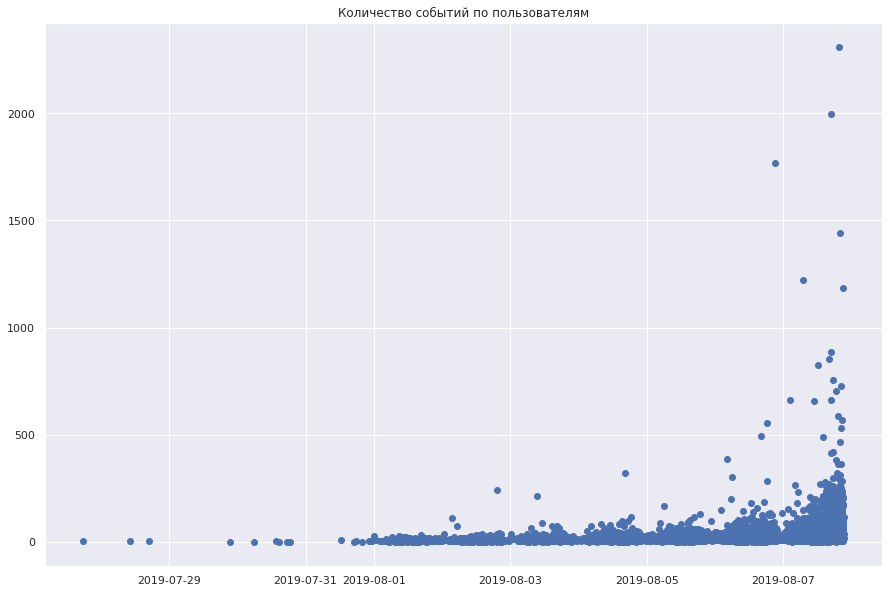

In [17]:
#график распределения событий по пользователям
plt.scatter(df_avg['event_dt'], df_avg['event_name'])
plt.title('Количество событий по пользователям')
plt.show()

Пользователей с аномальным кол-вом событий много, пока оставим

In [18]:
#посчитем минимальную дату
df['event_dt'].min()

Timestamp('2019-07-25 04:43:36')

In [19]:
#посчитаем максимальную дату
df['event_dt'].max()

Timestamp('2019-08-07 21:15:17')

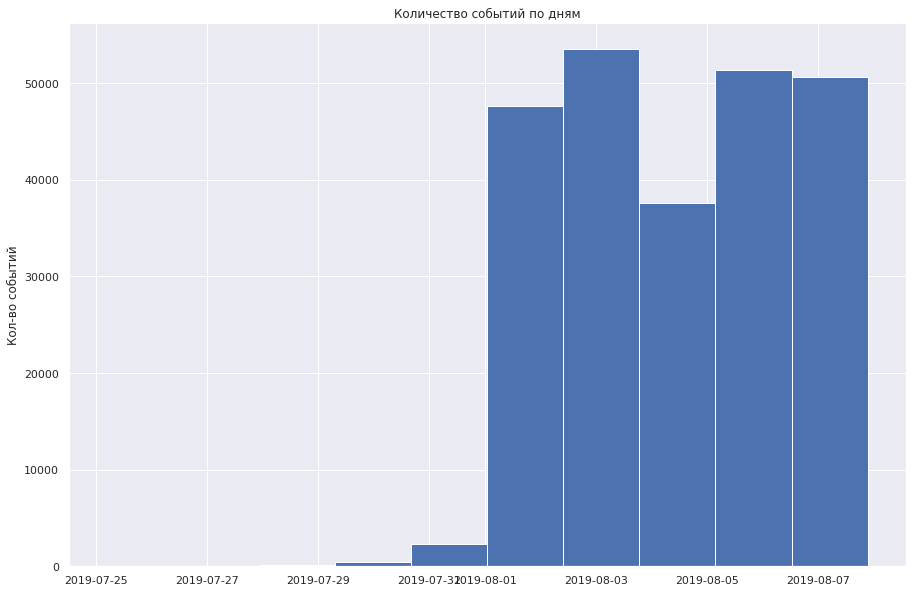

In [20]:
df['event_dt'].hist()
plt.title('Количество событий по дням')
plt.ylabel('Кол-во событий')
plt.show() 

Определил временной промежуток с 2019-08-01 по 2019-08-07

In [21]:
#датафрейм с актуальным временным горизонтом
df_new=df.query('event_dt >= "2019-08-01"')

In [22]:
#много ли событий пропало, отбросив старые данные
dis_event=(df['event_name'].count())-(df_new['event_name'].count())
print('Кол-во потерянных событий:', dis_event)

Кол-во потерянных событий: 2826


In [23]:
print('Доля потеряных событий:', round((dis_event/df['event_name'].count())*100, 2), '%')

Доля потеряных событий: 1.16 %


С новым горизнтом осталось 240887 событий, потеря - 2826 событий это менее 2%, не критично

In [24]:
#много ли пользователей потеряли, отбросив старые данные
df_user_total=df_new['user_id'].nunique()

In [25]:
dis_user=(df['user_id'].nunique())-(df_new['user_id'].nunique())
print('Кол-во потерянных пользователей:', dis_user)

Кол-во потерянных пользователей: 17


In [26]:
print('Доля потерянных пользователей:', round((dis_user/df['user_id'].nunique())*100, 2), '%')

Доля потерянных пользователей: 0.23 %


С новым горизнтом осталось 7534 пользователей, потеря - 17 пользователей это менее 1%, не критично

In [27]:
df_new.groupby('group').agg({'user_id':'nunique'})

,user_id
group,
246,2484
247,2513
248,2537


С новым горизнтом все три группы на месте и разница в кол-ве незначительная

## Изучите воронку событий

In [28]:
#какие события есть в логах
df_new.groupby('event_name').agg({'user_id':'count'}).sort_values(by='user_id', ascending=False)

,user_id
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


In [29]:
#сколько пользователей совершали каждое из этих событий
df_user_uniq = df_new.groupby('event_name').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False).reset_index()
df_user_uniq

,event_name,user_id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


В обоих случаях больше всего произошло событий MainScreenAppear (главная страница), составляет почти 50% от всего кол-ва. Далее идут OffersScreenAppear (предложения), CartScreenAppear (корзина) и PaymentScreenSuccessful (оплата), и в хвосте Tutorial (руководство)

In [30]:
#доля пользователей, которые совершили хотя бы одно событие
df_user_uniq['event_user_total'] = round((df_user_uniq['user_id']/df_user_total)*100, 2)
df_user_uniq

,event_name,user_id,event_user_total
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


Видно, что от всех уникальных пользователей до оплаты доходит 47%

In [31]:
#посчитаем по воронке событий, какая доля пользователей проходит на следующий шаг воронки
df_user_uniq['event_user_pr'] = round((df_user_uniq['user_id']/df_user_uniq['user_id'].shift(1, fill_value=0))*100, 2)
df_user_uniq

,event_name,user_id,event_user_total,event_user_pr
0,MainScreenAppear,7419,98.47,inf
1,OffersScreenAppear,4593,60.96,61.91
2,CartScreenAppear,3734,49.56,81.30
3,PaymentScreenSuccessful,3539,46.97,94.78
4,Tutorial,840,11.15,23.74


Переход из предложений в корзину всего лишь составил 49% от общего кол-ва, а переход из главной страницы на страницу предложений составил 37%

In [32]:
#копия фрейма с уникальными пользователями, для последующего удаления 'tutorial'
df_user_uniq_copy = df_user_uniq.copy()
df_user_uniq_copy.drop(labels = [4],axis = 0, inplace = True)

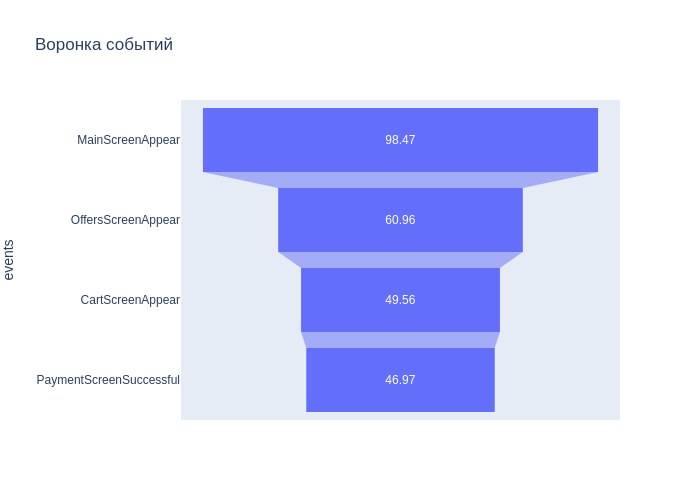

In [33]:
#график воронки событий по пользователям
fig = go.Figure(go.Funnel(x = df_user_uniq_copy['event_user_total'], y = df_user_uniq_copy['event_name']))
fig.update_layout (title='Воронка событий',
           yaxis_title='events')
fig.show()

## Изучите результаты эксперимента

    Нулевая гипотеза: нет оснований считать доли разным. 
    Альтернативная гипотеза: между долями есть значимая разница

In [34]:
#проверим статистические критерии разницу между выборками 246 и 247 с помощью функции
users_total=df.groupby('group')['user_id'].nunique()
users_total['246_247']=users_total[246]+users_total[247]

users_funnel=(
    df_new.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique')
    .reset_index()
    .sort_values(by=246, ascending=False)
)
users_funnel['246_247']=users_funnel[246] + users_funnel[247]

def  z (group1, group2, alpha):
    for i in users_funnel.index: 
        p1=users_funnel[group1][i]/users_total[group1]
        p2=users_funnel[ group2][i]/users_total[group2]
        p_combined=((users_funnel[group1][i]+users_funnel[group2][i])/(users_total[group1]+users_total[group2]))
        difference=p1-p2
        z_value=difference/mth.sqrt(p_combined*(1-p_combined)*(1/users_total[group1]+1/users_total[group2]))
        distr=stats.norm(0, 1)
        p_value=(1-distr.cdf(abs(z_value)))*2 
        print ('{}p-значение:{}'.format(users_funnel['event_name'][i], p_value)) 
        if (p_value<alpha ): 
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница') 
        else: 
            print('Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    
z(246, 247, 0.5)

MainScreenAppearp-значение:0.6194860229779078
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными
OffersScreenAppearp-значение:0.2352227460362717
Отвергаем нулевую гипотезу: между долями есть значимая разница
CartScreenAppearp-значение:0.21899829728450415
Отвергаем нулевую гипотезу: между долями есть значимая разница
PaymentScreenSuccessfulp-значение:0.10914759823712927
Отвергаем нулевую гипотезу: между долями есть значимая разница
Tutorialp-значение:0.9454168827071352
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [35]:
#проверим статистические критерии разницу между выборками 246 и 248
z(246, 248, 0.1)

MainScreenAppearp-значение:0.32916112087956995
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными
OffersScreenAppearp-значение:0.2097513010649208
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными
CartScreenAppearp-значение:0.07897406022802644
Отвергаем нулевую гипотезу: между долями есть значимая разница
PaymentScreenSuccessfulp-значение:0.21318312148591856
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Tutorialp-значение:0.8268596773192287
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [36]:
#проверим статистические критерии разницу между выборками 247 и 248
z(247, 248, 0.05)

MainScreenAppearp-значение:0.630511483398956
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными
OffersScreenAppearp-значение:0.948242051780652
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными
CartScreenAppearp-значение:0.598491352466854
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными
PaymentScreenSuccessfulp-значение:0.7174796792830545
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Tutorialp-значение:0.7731671969169724
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [37]:
#проверим статистические критерии разницу между выборками 246+247 и 248
z('246_247', 248, 0.05)

MainScreenAppearp-значение:0.39650789406907316
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными
OffersScreenAppearp-значение:0.44807592847340594
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными
CartScreenAppearp-значение:0.18799753938915797
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными
PaymentScreenSuccessfulp-значение:0.6123472065065059
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Tutorialp-значение:0.7696461997168715
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<b>Итоговый вывод:</b>

Остановить тест, изменение шрифта не повлияет на конверсию и увеличение продаж.